# Data Analytics project - prediction of electric current prices

### Libraries

In [1]:
import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from typing import List

from cmdstanpy import CmdStanModel
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importing data

#### Data 2019

In [2]:
df_ceny: pd.DataFrame = pd.read_csv("../Data/Prices/PL_CENY_NIEZB_RB_20190301_20190331.csv", sep=";", decimal=",")
df_zapotrzebowanie: pd.DataFrame = pd.read_csv("../Data/Load/PL_WYK_KSE_20190301_20190331.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny["Data_i_Godzina"] = df_ceny["Data"].astype(str) + " " + (df_ceny["Godzina"] - 1).astype(str)  # Hours 1-24, changed into 0-23
df_ceny["Data_i_Godzina"] = df_ceny["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y%m%d %H",))
df_ceny = df_ceny[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data"].astype(str) + " " + (df_zapotrzebowanie["Godzina"] - 1).astype(str) # Hours 1-24, changed into 0-23
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H",))
df_zapotrzebowanie["Dzień tygodnia"] = df_zapotrzebowanie["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_list: List[pd.DataFrame] = []
df_naslonecznienie_temp: pd.DataFrame
for file in os.listdir("../Data/Weather2019"):
    df_naslonecznienie_temp = pd.read_csv(f"../Data/Weather2019/{file}", header=6, skipfooter=11, engine="python")
    df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "G(i)", "T2m", "WS10m"]]
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(str.__getitem__, args=(slice(None, -2, None),))
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(datetime.datetime.strptime, args=("%Y%m%d:%H",))
    df_list.append(df_naslonecznienie_temp)
df_naslonecznienie: pd.DataFrame = pd.concat(df_list)
df_naslonecznienie = df_naslonecznienie.groupby("time").mean().reset_index()
df_naslonecznienie_marzec = df_naslonecznienie.loc[
    df_naslonecznienie["time"].between(datetime.datetime(2019, 3, 1), datetime.datetime(2019, 4, 1), inclusive="left")
    ]
df_naslonecznienie_marzec.reset_index(inplace=True)


#### Data 2020

In [3]:
df_ceny2020: pd.DataFrame = pd.read_csv("../Data/Prices/PL_CENY_NIEZB_RB_20200301_20200331.csv", sep=";", decimal=",")
df_zapotrzebowanie2020: pd.DataFrame = pd.read_csv("../Data/Load/PL_WYK_KSE_20200301_20200331.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny2020["Data_i_Godzina"] = df_ceny2020["Data"].astype(str) + " " + (df_ceny2020["Godzina"] - 1).astype(str)  # Hours 1-24, changed into 0-23
df_ceny2020["Data_i_Godzina"] = df_ceny2020["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y%m%d %H",))
df_ceny2020 = df_ceny2020[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie2020["Data_i_Godzina"] = df_zapotrzebowanie2020["Data"].astype(str) + " " + (df_zapotrzebowanie2020["Godzina"] - 1).astype(str) # Hours 1-24, changed into 0-23
df_zapotrzebowanie2020["Data_i_Godzina"] = df_zapotrzebowanie2020["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H",))
df_zapotrzebowanie2020["Dzień tygodnia"] = df_zapotrzebowanie2020["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_list2020: List[pd.DataFrame] = []
df_naslonecznienie_temp: pd.DataFrame
for file in os.listdir("../Data/Weather2020"):
    df_naslonecznienie_temp = pd.read_csv(f"../Data/Weather2020/{file}", header=6, skipfooter=11, engine="python")
    df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "Gb(i)", "Gd(i)", "Gr(i)", "T2m", "WS10m"]]
    df_naslonecznienie_temp["G(i)"] = df_naslonecznienie_temp[["Gb(i)", "Gd(i)", "Gr(i)"]].sum(axis=1)
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(str.__getitem__, args=(slice(None, -2, None),))
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(datetime.datetime.strptime, args=("%Y%m%d:%H",))
    df_list2020.append(df_naslonecznienie_temp)
df_naslonecznienie2020: pd.DataFrame = pd.concat(df_list2020)
df_naslonecznienie2020 = df_naslonecznienie2020.groupby("time").mean().reset_index()
df_naslonecznienie_marzec2020 = df_naslonecznienie2020.loc[
    df_naslonecznienie2020["time"].between(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 4, 1), inclusive="left")
    ]
df_naslonecznienie_marzec2020.reset_index(inplace=True)

## Load - prior

### Regression - finding coefficients for 5th degree polynomial regression

(96, 2)


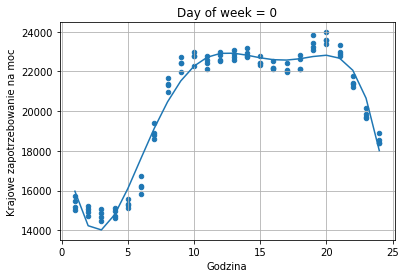

[-9.51772728e-02  6.17008966e+00 -1.46568872e+02  1.49657440e+03
 -5.29053654e+03  1.99003960e+04]
(96, 2)


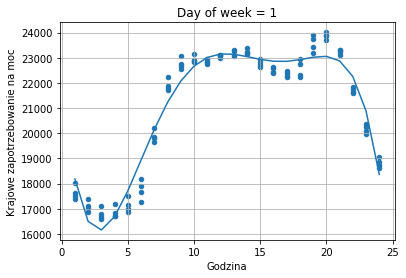

[-8.43528518e-02  5.43505860e+00 -1.28634403e+02  1.31740955e+03
 -4.81565452e+03  2.18021898e+04]
(96, 2)


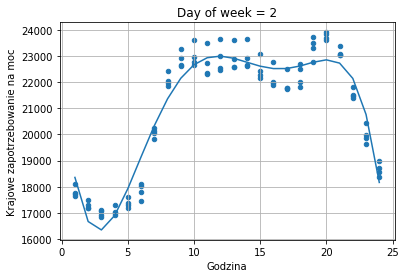

[-8.90020366e-02  5.69693666e+00 -1.33430694e+02  1.34777213e+03
 -4.87652548e+03  2.20120193e+04]
(96, 2)


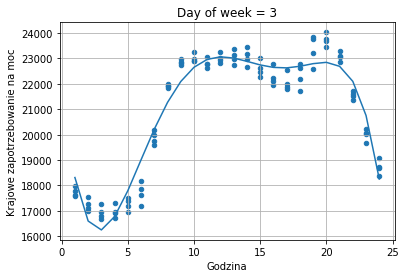

[-8.59978858e-02  5.53947530e+00 -1.30857786e+02  1.33570196e+03
 -4.88398998e+03  2.19871565e+04]
(120, 2)


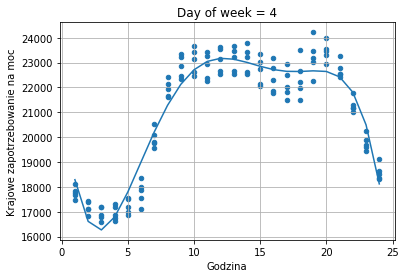

[-8.13782964e-02  5.28236019e+00 -1.25976021e+02  1.29779692e+03
 -4.76551107e+03  2.18751417e+04]
(120, 2)


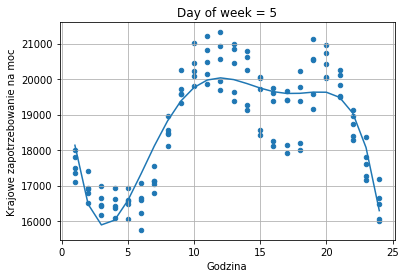

[-6.23679857e-02  4.06695537e+00 -9.78700150e+01  1.03192035e+03
 -4.13219885e+03  2.13306456e+04]
(119, 2)


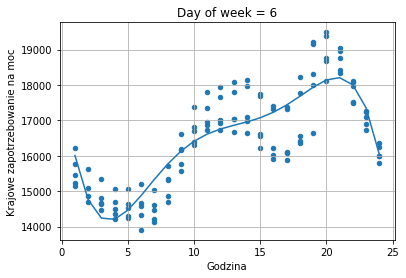

[-4.32771266e-02  2.74558358e+00 -6.47038340e+01  6.86344870e+02
 -2.89251536e+03  1.82766899e+04]


In [4]:
coeffs_demand: List[np.ndarray] = []
for day in range(7):
    data = df_zapotrzebowanie[["Godzina", "Krajowe zapotrzebowanie na moc"]].loc[df_zapotrzebowanie["Dzień tygodnia"] == day]
    print(data.shape)
    x = data["Godzina"]
    data.plot(x="Godzina", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True)
    plt.title(f"Day of week = {day}")
    coef = np.polyfit(x, data["Krajowe zapotrzebowanie na moc"], 5)  # Degree
    p = np.poly1d(coef)
    x = np.sort(x.drop_duplicates().to_numpy())
    plt.plot(x, p(x))
    plt.show()
    print(coef)
    coeffs_demand.append(coef)

### First prior - normal distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing


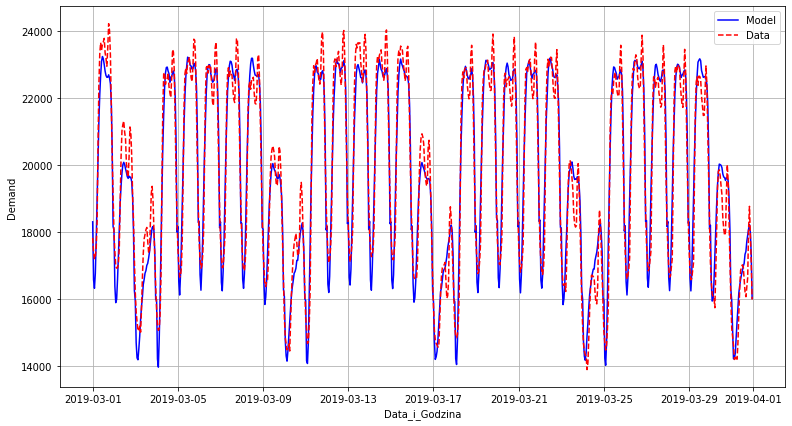

RMSE = 653.8428729968248


In [5]:
model_ppc=CmdStanModel(stan_file='model1.stan')
ppc = model_ppc.sample(show_progress=False, data=dict(
    N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, hour=df_zapotrzebowanie["Godzina"].values, 
    coeffs=coeffs_demand
    ))
df_ppc = ppc.draws_pd()
df_ppc_mean = df_ppc.mean()[[f"demand[{i}]" for i in range(1, len(df_zapotrzebowanie) + 1)]]
plt.figure(figsize=(13, 7))
plt.plot(df_zapotrzebowanie["Data_i_Godzina"], df_ppc_mean, "b-",
         df_zapotrzebowanie["Data_i_Godzina"], df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"], "r--")
plt.xlabel("Data_i_Godzina")
plt.ylabel("Demand")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.show()
print(f'RMSE = {mean_squared_error(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values, df_ppc_mean.values, squared=False)}')

### Second prior - T-Student distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


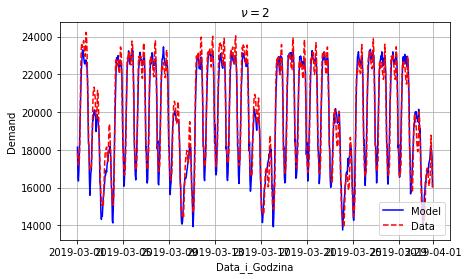

RMSE = 668.0890794353336


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


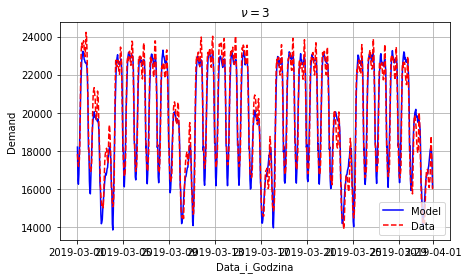

RMSE = 660.5758391316606


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing


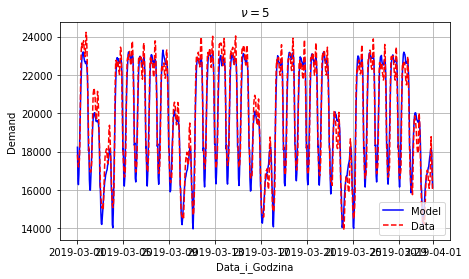

RMSE = 652.915467185914


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing


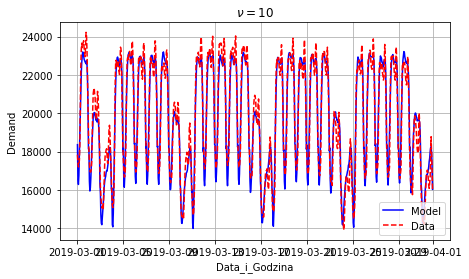

RMSE = 651.3448442093144


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing


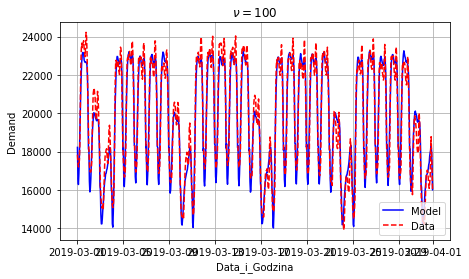

RMSE = 652.2439630172817


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing


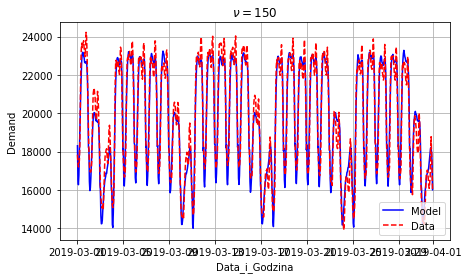

RMSE = 653.7464681753675


In [6]:
model_ppc2=CmdStanModel(stan_file='model2.stan')
for nu in [2, 3, 5, 10, 100, 150]:
    ppc2 = model_ppc2.sample(show_progress=False, data=dict(
        N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, hour=df_zapotrzebowanie["Godzina"].values, nu=nu, 
        coeffs=coeffs_demand
        ))
    df_ppc2 = ppc2.draws_pd()
    df_ppc_mean2 = df_ppc2.mean()[[f"demand[{i}]" for i in range(1, len(df_zapotrzebowanie) + 1)]]
    plt.figure(figsize=(7, 4))
    plt.plot(df_zapotrzebowanie["Data_i_Godzina"], df_ppc_mean2, "b-",
            df_zapotrzebowanie["Data_i_Godzina"], df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"], "r--")
    plt.xlabel("Data_i_Godzina")
    plt.ylabel("Demand")
    plt.grid(True)
    plt.legend(["Model", "Data"])
    plt.title(r"$\nu = $" + str(nu))
    plt.show()
    print(f'RMSE = {mean_squared_error(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values, df_ppc_mean2.values, squared=False)}')
    time.sleep(1)

Through experiments, it was determined that the best results (smallest value of RMSE) are achieved with nu = 5.

### Temperature's influence on the load

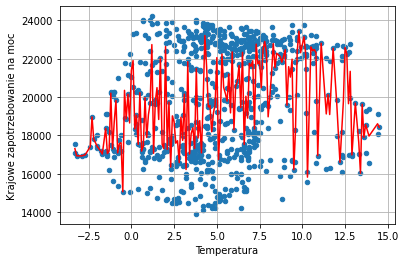

In [7]:
data = df_zapotrzebowanie[["Data_i_Godzina", "Godzina", "Krajowe zapotrzebowanie na moc"]]
# data = data[data["Godzina"].between(11, 21)]
data.insert(len(data.columns), "Temperatura", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["T2m"].values[0], 1) for i in range(len(data))
    ])
data.plot(x="Temperatura", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True)
plt.plot(sorted(data["Temperatura"].unique()), data.groupby(["Temperatura"], sort=True).median()["Krajowe zapotrzebowanie na moc"], "r-")
plt.show()

## Generation - prior

### Determining relation with wind speed and irradiance

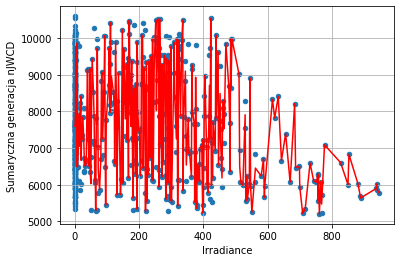

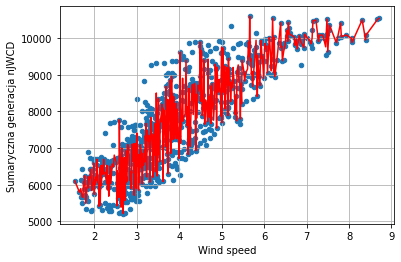

In [8]:
data = df_zapotrzebowanie[["Data_i_Godzina", "Sumaryczna generacja nJWCD"]]
data.insert(len(data.columns), "Irradiance", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["G(i)"].values[0], 0) for i in range(len(data))
    ])
data.insert(len(data.columns), "Wind speed", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["WS10m"].values[0], 2) for i in range(len(data))
    ])
data.plot(x="Irradiance", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True)
plt.plot(sorted(data["Irradiance"].unique()), data.groupby(["Irradiance"], sort=True).median()["Sumaryczna generacja nJWCD"], "r-")
plt.show()
data.plot(x="Wind speed", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True)
plt.plot(sorted(data["Wind speed"].unique()), data.groupby(["Wind speed"], sort=True).median()["Sumaryczna generacja nJWCD"], "r-")
plt.show()

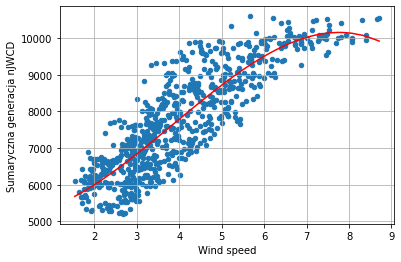

[ -20.98813787  242.92662548   23.92892529 5148.76715643]


In [9]:
x = data["Wind speed"]
data.plot(x="Wind speed", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True)
coef_generation = np.polyfit(x, data["Sumaryczna generacja nJWCD"], 3)  # Degree
p = np.poly1d(coef_generation)
x = np.sort(x.drop_duplicates().to_numpy())
plt.plot(x, p(x), "r-")
plt.show()
print(coef_generation)

### First prior - normal distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


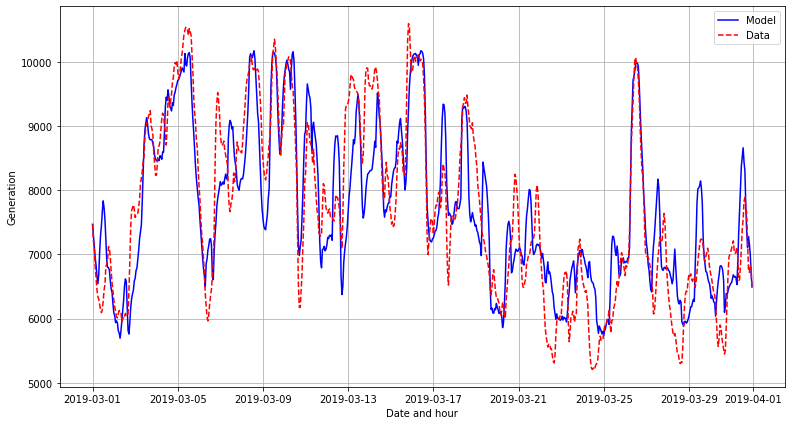

RMSE = 685.9175172197163


In [10]:
model_ppc3=CmdStanModel(stan_file='model3.stan')
ppc3 = model_ppc3.sample(show_progress=False, data=dict(
    N=len(data), wind_speed=data["Wind speed"].values, coeffs=coef_generation
    ))
df_ppc3 = ppc3.draws_pd()
df_ppc_mean3 = df_ppc3.mean()[[f"generation[{i}]" for i in range(1, len(data) + 1)]]
plt.figure(figsize=(13, 7))
plt.plot(data["Data_i_Godzina"], df_ppc_mean3, "b-",
         data["Data_i_Godzina"], data["Sumaryczna generacja nJWCD"], "r--")
plt.xlabel("Date and hour")
plt.ylabel("Generation")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.show()
print(f'RMSE = {mean_squared_error(data["Sumaryczna generacja nJWCD"].values, df_ppc_mean3.values, squared=False)}')

### Second prior - T-Student distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing


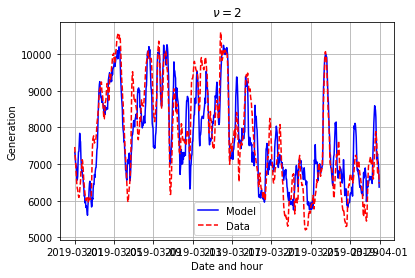

RMSE = 690.6314193968446


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


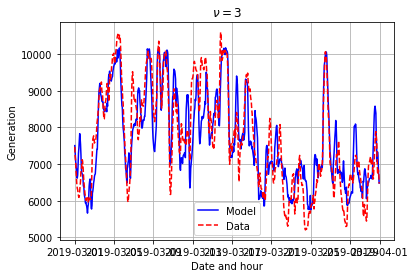

RMSE = 688.5557120217202


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing


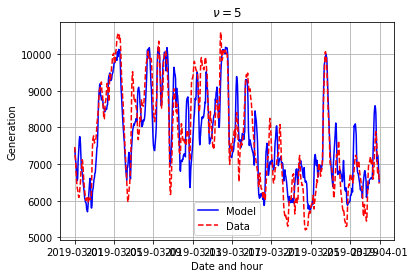

RMSE = 684.9931788785007


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


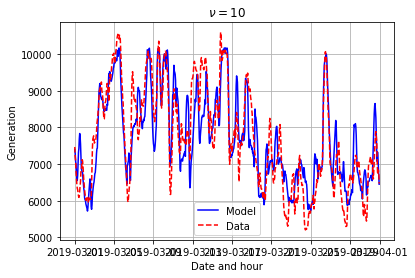

RMSE = 687.2965587823704


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


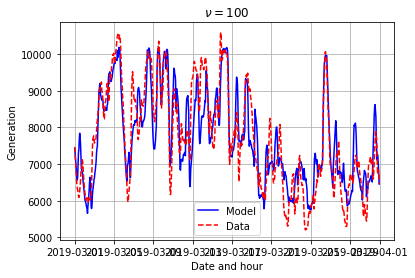

RMSE = 685.3234485974582


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing


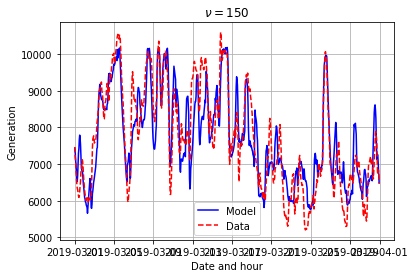

RMSE = 685.6614165443744


In [11]:
model_ppc4=CmdStanModel(stan_file='model4.stan')
for nu in [2, 3, 5, 10, 100, 150]:
    ppc4 = model_ppc4.sample(show_progress=False, data=dict(
        N=len(data), wind_speed=data["Wind speed"].values, coeffs=coef_generation, nu=nu
        ))
    df_ppc4 = ppc4.draws_pd()
    df_ppc_mean4 = df_ppc4.mean()[[f"generation[{i}]" for i in range(1, len(data) + 1)]]
    plt.plot(data["Data_i_Godzina"], df_ppc_mean4, "b-",
            data["Data_i_Godzina"], data["Sumaryczna generacja nJWCD"], "r--")
    plt.xlabel("Date and hour")
    plt.ylabel("Generation")
    plt.grid(True)
    plt.legend(["Model", "Data"])
    plt.title(r"$\nu = $" + str(nu))
    plt.show()
    print(f'RMSE = {mean_squared_error(data["Sumaryczna generacja nJWCD"].values, df_ppc_mean4.values, squared=False)}')
    time.sleep(1)

Again, the best amount of degrees of freedom is 5.

## Prices - prior

### Determining the relation with the residual load (Load - generation)

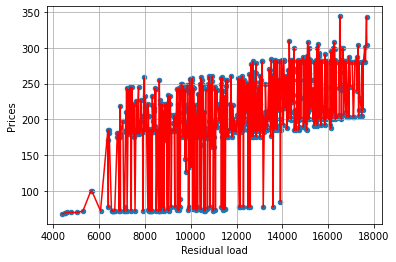

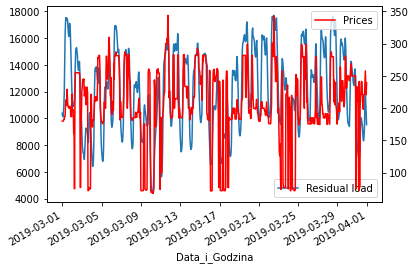

In [12]:
data = df_zapotrzebowanie.loc[:, ["Data_i_Godzina", "Sumaryczna generacja nJWCD", "Sumaryczna generacja JWCD", "Krajowe zapotrzebowanie na moc", "Dzień tygodnia"]]
data.insert(len(data.columns), "Prices", [
    df_ceny.loc[df_ceny["Data_i_Godzina"] == data.iloc[i]["Data_i_Godzina"]]["CRO"].values[0] for i in range(len(data))
    ])
# data = data[data["Dzień tygodnia"].between(0, 4, "both")]
# data = data[data["Prices"] > 150]
data["Residual load"] = data["Krajowe zapotrzebowanie na moc"] - data["Sumaryczna generacja nJWCD"]

data.plot(x="Residual load", y="Prices", kind="scatter", grid=True)
plt.plot(sorted(data["Residual load"].unique()), data.groupby(["Residual load"], sort=True).median()["Prices"], "r-")
plt.show()
ax = data.plot(x="Data_i_Godzina", y="Residual load")
ax2 = ax.twinx()
data.plot(x="Data_i_Godzina", y="Prices", ax=ax2, style="r-")
plt.show()

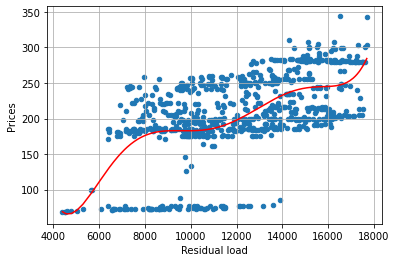

[-7.74260948e-26  1.02726525e-20 -4.78548203e-16  1.09884929e-11
 -1.38004639e-07  9.56137533e-04 -3.36908799e+00  4.73605231e+03]


In [13]:
x = data["Residual load"]
data.plot(x="Residual load", y="Prices", kind="scatter", grid=True)
coef_prices = np.polyfit(x, data["Prices"], 7)  # Degree
p = np.poly1d(coef_prices)
x = np.sort(x.drop_duplicates().to_numpy())
plt.plot(x, p(x), "r-")
plt.show()
print(coef_prices)

### First prior - normal distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing


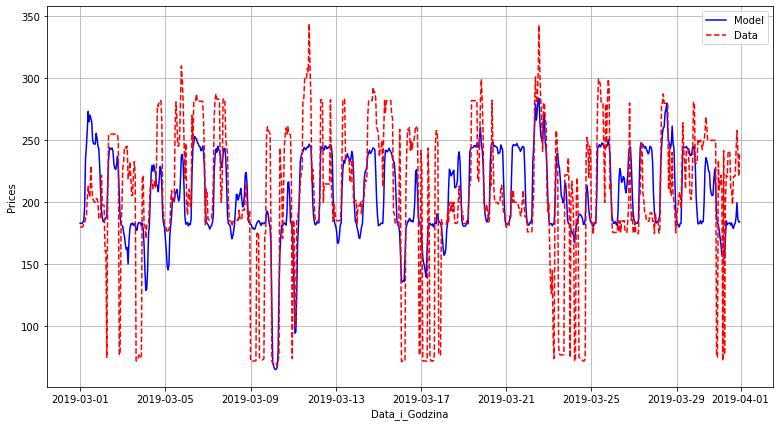

RMSE = 47.22193312908426


In [14]:
model_ppc5=CmdStanModel(stan_file='model5.stan')
ppc5 = model_ppc5.sample(show_progress=False, data=dict(
    N=len(data), residual=data["Residual load"].values, coeffs=coef_prices
    ))
df_ppc5 = ppc5.draws_pd()
df_ppc_mean5 = df_ppc5.mean()[[f"prices[{i}]" for i in range(1, len(data) + 1)]]
plt.figure(figsize=(13, 7))
plt.plot(data["Data_i_Godzina"], df_ppc_mean5, "b-",
         data["Data_i_Godzina"], data["Prices"], "r--")
plt.xlabel("Data_i_Godzina")
plt.ylabel("Prices")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.show()
print(f'RMSE = {mean_squared_error(data["Prices"].values, df_ppc_mean5.values, squared=False)}')

### Second prior - T-Student distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


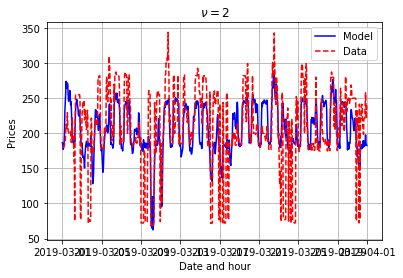

RMSE = 47.48945867394853


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


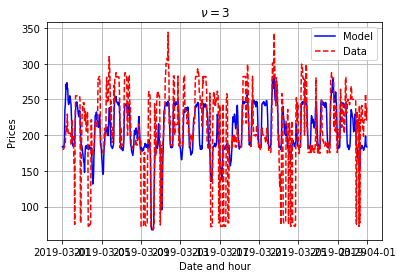

RMSE = 47.18267004938803


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing


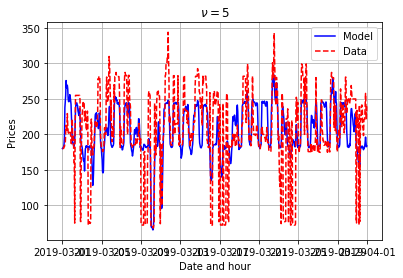

RMSE = 47.19588798625366


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing


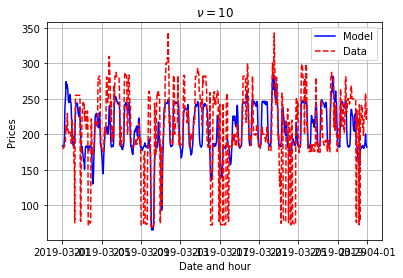

RMSE = 47.214956820085185


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


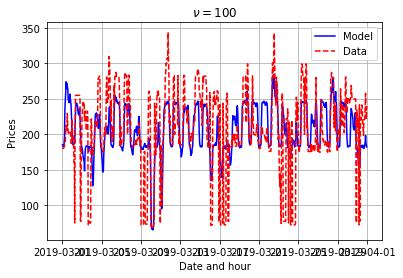

RMSE = 47.22022251245893


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing


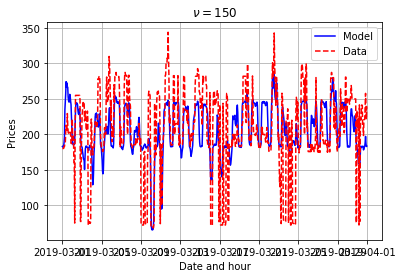

RMSE = 47.23294828473836


In [15]:
model_ppc6=CmdStanModel(stan_file='model6.stan')
for nu in [2, 3, 5, 10, 100, 150]:
    ppc6 = model_ppc6.sample(show_progress=False, data=dict(
        N=len(data), residual=data["Residual load"].values, coeffs=coef_prices, nu=nu
        ))
    df_ppc6 = ppc6.draws_pd()
    df_ppc_mean6 = df_ppc6.mean()[[f"prices[{i}]" for i in range(1, len(data) + 1)]]
    plt.plot(data["Data_i_Godzina"], df_ppc_mean6, "b-",
            data["Data_i_Godzina"], data["Prices"], "r--")
    plt.xlabel("Date and hour")
    plt.ylabel("Prices")
    plt.grid(True)
    plt.legend(["Model", "Data"])
    plt.title(r"$\nu = $" + str(nu))
    plt.show()
    print(f'RMSE = {mean_squared_error(data["Prices"].values, df_ppc_mean6.values, squared=False)}')
    time.sleep(1)

The smallest value of RMSE was reached with $\nu$ = 3

## Posterior

In [1]:
data1 = df_zapotrzebowanie.loc[:, ["Dzień tygodnia", "Godzina", "Data_i_Godzina"]]
data1.insert(len(data1.columns), "Wind speed", [
    round(df_naslonecznienie_marzec.loc[
        df_naslonecznienie_marzec["time"] == data1.iloc[i]["Data_i_Godzina"]
        ]["WS10m"].values[0], 2) for i in range(len(data1))
    ])
data1.insert(len(data1.columns), "Prices", [
    df_ceny.loc[df_ceny["Data_i_Godzina"] == data1.iloc[i]["Data_i_Godzina"]]["CRO"].values[0] for i in range(len(data1))
    ])
data2 = df_zapotrzebowanie2020.loc[:, ["Dzień tygodnia", "Godzina", "Data_i_Godzina"]]
data2.insert(len(data2.columns), "Wind speed", [
    round(df_naslonecznienie_marzec2020.loc[
        df_naslonecznienie_marzec2020["time"] == data2.iloc[i]["Data_i_Godzina"]
        ]["WS10m"].values[0], 2) for i in range(len(data2))
    ])
data2.insert(len(data2.columns), "Prices", [
    df_ceny2020.loc[df_ceny2020["Data_i_Godzina"] == data2.iloc[i]["Data_i_Godzina"]]["CRO"].values[0] for i in range(len(data2))
    ])
model_posterior = CmdStanModel(stan_file='posterior.stan')
posterior = model_posterior.sample(show_progress=False, data=dict(
    N_historic=len(data1), N_predict=len(data2), prices_historic=data1["Prices"].values, day_of_week_historic=data1["Dzień tygodnia"].values, 
    hour_historic=data1["Godzina"].values, wind_speed_historic=data1["Wind speed"].values, day_of_week_predict=data2["Dzień tygodnia"].values, 
    hour_predict=data2["Godzina"].values, wind_speed_predict=data2["Wind speed"].values, coeffs_demand=coeffs_demand, 
    coeffs_generation=coef_generation, coeffs_prices=coef_prices
    ))
df_posterior = posterior.draws_pd()
df_posterior_mean = df_posterior.mean()[[f"posterior_prices[{i}]" for i in range(1, len(data2) + 1)]]
plt.plot(data2["Data_i_Godzina"], df_posterior_mean, "b-",
        data2["Data_i_Godzina"], data2["Prices"], "r--")
plt.xlabel("Date and hour")
plt.ylabel("Prices")
plt.grid(True)
plt.legend(["Model", "Data"])
plt.show()
print(f'RMSE = {mean_squared_error(data2["Prices"].values, df_posterior_mean.values, squared=False)}')

NameError: name 'df_zapotrzebowanie' is not defined